In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l
import time
import pathlib
data_dir = 'C:/Users/eaind/ocr/13Sep21Model/cnnpro/data'


def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))


def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(
        tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(39)]))
    return net

net = vgg(conv_arch)


X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)
    

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = lambda: vgg(small_conv_arch)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 39)


In [3]:
img_height, img_width = 224, 224  
batch_size = 256


train_iter = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_iter = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 21897 files belonging to 39 classes.
Using 17518 files for training.
Found 21897 files belonging to 39 classes.
Using 4379 files for validation.


In [4]:
#@tab tensorflow
class TrainCallback(tf.keras.callbacks.Callback):  #@save
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        if(logs.get('loss')<0.02):
            print("\nReached 98% accuracy so cancelling training!")
            self.net.stop_training = True
        self.timer.stop()
        test_acc = self.net.evaluate(self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, 'f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on 'f'{str(self.device_name)}')

#@save
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs, device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

loss 0.571, train acc 0.840, test acc 0.893
14.4 examples/sec on /CPU:0


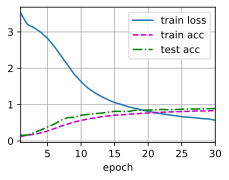

In [5]:
lr, num_epochs = 0.001, 30  #bs=256
model = train_ch6(net, train_iter, val_iter, num_epochs, lr, d2l.try_gpu())

In [7]:
model.summary()
model.save('savemodel/vggnet_ep30lr0p001bs256.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 112, 112, 16)      448       
_________________________________________________________________
sequential_9 (Sequential)    (None, 56, 56, 32)        4640      
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28, 64)        55424     
_________________________________________________________________
sequential_11 (Sequential)   (None, 14, 14, 128)       221440    
_________________________________________________________________
sequential_12 (Sequential)   (None, 7, 7, 128)         295168    
_________________________________________________________________
sequential_13 (Sequential)   (None, 39)                42635303  
Total params: 43,212,423
Trainable params: 43,212,423
Non-trainable params: 0
__________________________________________